![Py4Eng](../logo.png)

# Finetuning pretrained model
## Yoav Ram

This notebook shows a simple, step-by-step finetuning workflow using a pretrained [EfficientNetV2](https://arxiv.org/pdf/2104.00298) backbone (from `timm`) and PyTorch. The target dataset is the [Hyena ID 2022](https://lila.science/datasets/hyena-id-2022/) dataset (3104 photos, 256 individuals) — the task is per-individual classification.

We will load the pretrained model using [`timm`](https://timm.fast.ai), a collection of state-of-the-art computer vision models. Install it with `pip install timm`.

In [1]:
%matplotlib inline
import os
import shutil
from collections import Counter
import tarfile
import urllib.request
import random
from tqdm import tqdm
from pathlib import Path
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_metric_learning.losses import ArcFaceLoss

print('torch', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

/home/jupyter-yoavram/miniforge3/envs/DataSciPy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch 2.7.1
Device: cuda


# Data

We Download the [Hyena ID 2022 dataset](https://lila.science/datasets/hyena-id-2022/) and extract to `data/hyena`. 

In [2]:
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
chunk = 1024 * 1024

os.makedirs(os.path.dirname(out_path), exist_ok=True)

In [3]:
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        with urllib.request.urlopen(url) as r, open(out_path, 'wb') as f:
            total = r.getheader('Content-Length')
            total = int(total) if total else None
            with tqdm(total=total, unit='B', unit_scale=True, desc='download') as p:
                while True:
                    data = r.read(chunk)
                    if not data:
                        break
                    f.write(data)
                    p.update(len(data))
    else:
        print(f'File {out_path} already exists, skipping download.')

    print(f"Extracting {out_path}")
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print(f'Extraction directory already exists, skipping extraction.')

Extraction directory already exists, skipping extraction.



The metadata is in `../data/hyena/hyena.coco/annotations/instances_train2022.json`, which contains the bounding box of the individuals in the images, as well as their the identities.

Load COCO-style annotations and build mapping from filename to identity.

In [4]:
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json', 'r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}

All the hyena images are now in `../data/hyena/hyena.coco/images/train2022` folder (`test2022` and `val2022` are empty). Image filenames are just the image running number.

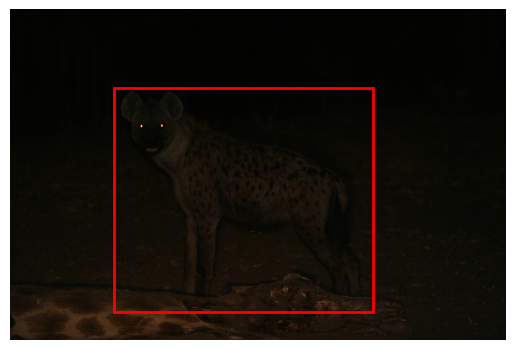

In [5]:
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'

def plot_image(image_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    path = path_template.format(image_id)
    image = Image.open(path)    
    ax.imshow(image)
    bbox = bboxes[image_id]
    x, y, w, h = bbox  # Top-Left X, Top-Left Y, Width, Height
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', lw=2)
    ax.add_patch(rect)
    ax.axis('off')
    return ax

plot_image(np.random.randint(1, len(bboxes)+1));

Now we get the labels -- individual names.

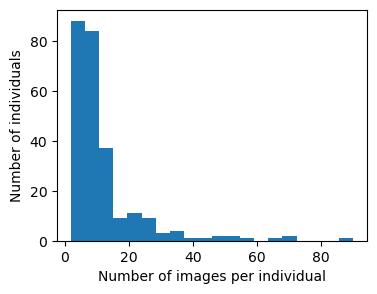

In [6]:
img2name = {a['image_id']: a['name'] for a in metadata['annotations']}
img_ids = np.array(list(img2name.keys()))

counter = Counter(img2name.values())
plt.figure(figsize=(4, 3))
plt.hist(counter.values(), 20)
plt.xlabel('Number of images per individual')
plt.ylabel('Number of individuals');

Map names to integers and back.

In [7]:
name2id = {k:i for i,k in enumerate(counter.keys())}
int2name = {i:k for k,i in name2id.items()}
labels = np.array([name2id[img2name[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print("Number of classes:", n_classes)

Number of classes: 256


Split to train and test sets by defining the indexes that go to either set.

In [8]:
rng = np.random.default_rng(23)
# Use a stratified split so each individual is represented in train and val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print("Number of train samples {}\nNumber of validation samples {}".format(len(train_idx), len(val_idx)))

Number of train samples 2793
Number of validation samples 311


We now define a dataset class that takes image identifiers and their corresponding labels and on each iteration loads and returns an image and its label.

In [9]:
class HyenaDataset(Dataset):    
    def __init__(self, img_ids, labels, transform=None):
        assert len(img_ids) == len(labels)
        self.img_ids = img_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        image_id = self.img_ids[idx]
        label = self.labels[idx]
        path = path_template.format(image_id)
        image = Image.open(path).convert('RGB')
        # crop to bbox
        bbox = bboxes[image_id]
        x, y, w, h = bbox
        image = image.crop((x, y, x + w, y + h))
        if self.transform:
            image = self.transform(image)
        return image, label
    

Definte the image transforms: resize to the image size suitable for the model, convert to PyTorch tensor, and normalize colors. For the training transforms, we also augment the data using horizontal flips.

In [10]:
img_size = 224

val_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    # T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transforms = T.Compose([
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

Now we create the datasets and data loaders.

In [11]:
batch_size = 64

train_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=train_transforms)
val_ds = HyenaDataset(img_ids=img_ids[val_idx], labels=labels[val_idx], transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8)

Here's how the images look like coming out of the data set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1632845].


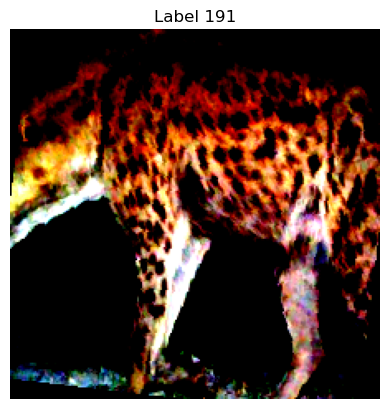

In [12]:
img, lbl = next(iter(train_ds))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Label {lbl}');

## Model
Load a pretrained **EfficientNetV2_s** without the classifier head. We use the small variant `_s` for speed; change to `_m` or `_l` if you want.
See [model card](https://huggingface.co/timm/tf_efficientnetv2_s.in21k_ft_in1k) for details.

In [13]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True, # 
    num_classes=0,  # remove classifier
)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

Let's see the model in action. Because we specificed `num_classes=0`, the output is the last activation (that the classifier used as input during pretraining), which is called the **embedding**.

In [14]:
embedding = model(img.unsqueeze(0))
print("Embedding shape:", embedding.shape)
print(embedding)
del img

Embedding shape: torch.Size([1, 1280])
tensor([[0.4531, 0.4532, 0.3154,  ..., 0.4217, 0.3595, 0.5552]],
       grad_fn=<ViewBackward0>)


We now create the [ArcFace loss](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#arcfaceloss) function. Note that this loss function is parameterized--it has weights for a linear classification layer.

In [15]:
loss_fn = ArcFaceLoss(num_classes=n_classes, embedding_size=embedding.shape[1], margin=0.35, scale=30.0)

We now move the model to the device (gpu/mps/cpu) and print it.

### Freeze backbone and train classifier head
We freeze all parameters except the classifier parameters.

In [16]:
# Freeze backbone
for p in model.parameters():
    p.requires_grad = False
# Train the loss function parameters
for p in loss_fn.parameters():
    p.requires_grad = True

Define an optimizer for the model parameters and for the loss function parameters. Use *AdamW* with small weight decay to reduce overfitting.

In [17]:
loss_optimizer = torch.optim.AdamW(loss_fn.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

Define a function to train the model for one epoch and another function to evaluate it at the end of the epoch.

In [18]:
def train(model, loss_fn, data_loader, optimizer, loss_optimizer):
    model.train()
    running_loss = 0.0 # for the entire epoch
    pbar = tqdm(data_loader, desc='Training', unit='batch')
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        emb = model(x)
        loss = loss_fn(emb, y)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix({'loss': f'{loss:.4f}'})
    return running_loss / len(data_loader.dataset)

In [19]:
def evaluate(model, loss_fn, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            emb = model(x)            
            logits = emb @ loss_fn.W
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total if total else 0.0

Now let's train just the ArcFace classifier (the backbone is frozen) for 3 epochs. We first move the model and loss function to the accelerator device.

In [20]:
model.to(device)
loss_fn = loss_fn.to(device)

val_acc = []
train_acc = []
n_epochs = 5
epoch = 0
train_acc.append(evaluate(model, loss_fn, train_loader))
val_acc.append(evaluate(model, loss_fn, val_loader))
print(f'Before training: train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer, loss_optimizer)
    train_acc.append(evaluate(model, loss_fn, train_loader))
    val_acc.append(evaluate(model, loss_fn, val_loader))
    scheduler.step(val_acc[-1])
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
    epoch += 1

Before training: train acc 0.0029 | val acc 0.0064


Training: 100%|██████████| 44/44 [00:14<00:00,  3.01batch/s, loss=5.9889]


Epoch 1/5: loss 5.9661 | train acc 0.0079 | val acc 0.0161


Training: 100%|██████████| 44/44 [00:15<00:00,  2.93batch/s, loss=5.7612]


Epoch 2/5: loss 5.7577 | train acc 0.0183 | val acc 0.0161


Training: 100%|██████████| 44/44 [00:14<00:00,  3.07batch/s, loss=5.6920]


Epoch 3/5: loss 5.5715 | train acc 0.0272 | val acc 0.0257


Training: 100%|██████████| 44/44 [00:14<00:00,  3.07batch/s, loss=5.3570]


Epoch 4/5: loss 5.4425 | train acc 0.0279 | val acc 0.0289


Training: 100%|██████████| 44/44 [00:14<00:00,  2.95batch/s, loss=5.3697]


Epoch 5/5: loss 5.3076 | train acc 0.0387 | val acc 0.0322


### Unfreeze and finetune the whole model
Now we unfreeze all parameters and create a new optimizer for all the parameters with a lower learning rate.

In [21]:
for p in model.parameters():
    p.requires_grad = True

Now continue training the entire model (backbone+head).
This typically improves performance but takes longer - 70 min of a MacBookPro 2025 with MPS.

In [22]:
n_epochs = 100
print(f'Before training: val_acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer, loss_optimizer)
    train_acc.append(evaluate(model, loss_fn, train_loader))
    val_acc.append(evaluate(model, loss_fn, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train_acc {train_acc[-1]:.4f} | val_acc {val_acc[-1]:.4f}')
    epoch += 1

Before training: val_acc 0.0322


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=4.9773]


Epoch 6/100: loss 5.1681 | train_acc 0.0687 | val_acc 0.0418


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=4.7909]


Epoch 7/100: loss 4.9666 | train_acc 0.1003 | val_acc 0.0740


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=4.8864]


Epoch 8/100: loss 4.7468 | train_acc 0.1418 | val_acc 0.1125


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=4.6975]


Epoch 9/100: loss 4.5425 | train_acc 0.1686 | val_acc 0.1415


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=4.3679]


Epoch 10/100: loss 4.3844 | train_acc 0.1944 | val_acc 0.1833


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=3.6188]


Epoch 11/100: loss 4.2129 | train_acc 0.2223 | val_acc 0.1897


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=4.0164]


Epoch 12/100: loss 4.0597 | train_acc 0.2427 | val_acc 0.2122


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=3.7741]


Epoch 13/100: loss 3.8785 | train_acc 0.2796 | val_acc 0.2283


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=3.6477]


Epoch 14/100: loss 3.7457 | train_acc 0.3097 | val_acc 0.2508


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=3.5789]


Epoch 15/100: loss 3.5913 | train_acc 0.3348 | val_acc 0.2733


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=3.3304]


Epoch 16/100: loss 3.4579 | train_acc 0.3656 | val_acc 0.2894


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=3.3650]


Epoch 17/100: loss 3.3182 | train_acc 0.3963 | val_acc 0.3119


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=3.0596]


Epoch 18/100: loss 3.1966 | train_acc 0.4339 | val_acc 0.3344


Training: 100%|██████████| 44/44 [00:16<00:00,  2.59batch/s, loss=3.2048]


Epoch 19/100: loss 3.0919 | train_acc 0.4579 | val_acc 0.3505


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=3.0898]


Epoch 20/100: loss 2.9650 | train_acc 0.4801 | val_acc 0.3601


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=2.7673]


Epoch 21/100: loss 2.8594 | train_acc 0.5166 | val_acc 0.3794


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=2.7300]


Epoch 22/100: loss 2.7409 | train_acc 0.5442 | val_acc 0.3794


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=2.3088]


Epoch 23/100: loss 2.6256 | train_acc 0.5607 | val_acc 0.3987


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=2.4713]


Epoch 24/100: loss 2.5423 | train_acc 0.5868 | val_acc 0.4019


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=2.3883]


Epoch 25/100: loss 2.4272 | train_acc 0.6062 | val_acc 0.4051


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=2.2562]


Epoch 26/100: loss 2.3415 | train_acc 0.6391 | val_acc 0.4180


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=2.1931]


Epoch 27/100: loss 2.2533 | train_acc 0.6660 | val_acc 0.4341


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=2.3547]


Epoch 28/100: loss 2.1587 | train_acc 0.6978 | val_acc 0.4534


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=2.1403]


Epoch 29/100: loss 2.1036 | train_acc 0.7136 | val_acc 0.4534


Training: 100%|██████████| 44/44 [00:17<00:00,  2.56batch/s, loss=1.6725]


Epoch 30/100: loss 1.9916 | train_acc 0.7376 | val_acc 0.4695


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=1.9477]


Epoch 31/100: loss 1.9355 | train_acc 0.7587 | val_acc 0.4727


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=2.1983]


Epoch 32/100: loss 1.8458 | train_acc 0.7698 | val_acc 0.4920


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=2.0530]


Epoch 33/100: loss 1.7696 | train_acc 0.7934 | val_acc 0.4952


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=1.7361]


Epoch 34/100: loss 1.6958 | train_acc 0.8074 | val_acc 0.5016


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=1.4914]


Epoch 35/100: loss 1.6247 | train_acc 0.8299 | val_acc 0.5145


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=1.4453]


Epoch 36/100: loss 1.5580 | train_acc 0.8457 | val_acc 0.5209


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=1.4955]


Epoch 37/100: loss 1.4984 | train_acc 0.8561 | val_acc 0.5305


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=1.4426]


Epoch 38/100: loss 1.4365 | train_acc 0.8700 | val_acc 0.5466


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=1.4087]


Epoch 39/100: loss 1.3826 | train_acc 0.8765 | val_acc 0.5498


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=1.1700]


Epoch 40/100: loss 1.3279 | train_acc 0.8897 | val_acc 0.5498


Training: 100%|██████████| 44/44 [00:16<00:00,  2.69batch/s, loss=1.2057]


Epoch 41/100: loss 1.2721 | train_acc 0.9033 | val_acc 0.5563


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=1.5393]


Epoch 42/100: loss 1.2085 | train_acc 0.9119 | val_acc 0.5723


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=1.3564]


Epoch 43/100: loss 1.1667 | train_acc 0.9180 | val_acc 0.5723


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=1.2670]


Epoch 44/100: loss 1.1072 | train_acc 0.9273 | val_acc 0.5852


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.9433]


Epoch 45/100: loss 1.0397 | train_acc 0.9363 | val_acc 0.5852


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=1.0141]


Epoch 46/100: loss 1.0155 | train_acc 0.9449 | val_acc 0.5949


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.7950]


Epoch 47/100: loss 0.9694 | train_acc 0.9477 | val_acc 0.5949


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=1.1133]


Epoch 48/100: loss 0.9083 | train_acc 0.9481 | val_acc 0.6013


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.9381]


Epoch 49/100: loss 0.8713 | train_acc 0.9642 | val_acc 0.5949


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.9630]


Epoch 50/100: loss 0.8312 | train_acc 0.9617 | val_acc 0.5981


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.7246]


Epoch 51/100: loss 0.7935 | train_acc 0.9696 | val_acc 0.6045


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.9237]


Epoch 52/100: loss 0.7667 | train_acc 0.9703 | val_acc 0.6141


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.6908]


Epoch 53/100: loss 0.7163 | train_acc 0.9774 | val_acc 0.6077


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.8342]


Epoch 54/100: loss 0.6934 | train_acc 0.9771 | val_acc 0.6238


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.5527]


Epoch 55/100: loss 0.6570 | train_acc 0.9796 | val_acc 0.6302


Training: 100%|██████████| 44/44 [00:16<00:00,  2.67batch/s, loss=0.6777]


Epoch 56/100: loss 0.6125 | train_acc 0.9868 | val_acc 0.6302


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.5109]


Epoch 57/100: loss 0.5822 | train_acc 0.9810 | val_acc 0.6270


Training: 100%|██████████| 44/44 [00:16<00:00,  2.66batch/s, loss=0.6567]


Epoch 58/100: loss 0.5650 | train_acc 0.9842 | val_acc 0.6431


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.5478]


Epoch 59/100: loss 0.5295 | train_acc 0.9900 | val_acc 0.6431


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.6608]


Epoch 60/100: loss 0.5037 | train_acc 0.9907 | val_acc 0.6399


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=0.6640]


Epoch 61/100: loss 0.4748 | train_acc 0.9928 | val_acc 0.6399


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.4610]


Epoch 62/100: loss 0.4547 | train_acc 0.9907 | val_acc 0.6495


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.5006]


Epoch 63/100: loss 0.4359 | train_acc 0.9900 | val_acc 0.6527


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.5731]


Epoch 64/100: loss 0.4158 | train_acc 0.9950 | val_acc 0.6592


Training: 100%|██████████| 44/44 [00:16<00:00,  2.66batch/s, loss=0.3920]


Epoch 65/100: loss 0.3919 | train_acc 0.9950 | val_acc 0.6656


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.4391]


Epoch 66/100: loss 0.3617 | train_acc 0.9943 | val_acc 0.6592


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.3894]


Epoch 67/100: loss 0.3493 | train_acc 0.9971 | val_acc 0.6559


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.3061]


Epoch 68/100: loss 0.3341 | train_acc 0.9953 | val_acc 0.6656


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.3795]


Epoch 69/100: loss 0.3139 | train_acc 0.9953 | val_acc 0.6720


Training: 100%|██████████| 44/44 [00:16<00:00,  2.66batch/s, loss=0.3631]


Epoch 70/100: loss 0.3033 | train_acc 0.9950 | val_acc 0.6752


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.3499]


Epoch 71/100: loss 0.2858 | train_acc 0.9982 | val_acc 0.6849


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.3286]


Epoch 72/100: loss 0.2747 | train_acc 0.9975 | val_acc 0.6785


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.2690]


Epoch 73/100: loss 0.2671 | train_acc 0.9986 | val_acc 0.6817


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.2733]


Epoch 74/100: loss 0.2517 | train_acc 0.9986 | val_acc 0.6881


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.3220]


Epoch 75/100: loss 0.2375 | train_acc 0.9982 | val_acc 0.6785


Training: 100%|██████████| 44/44 [00:16<00:00,  2.60batch/s, loss=0.3351]


Epoch 76/100: loss 0.2286 | train_acc 0.9968 | val_acc 0.6785


Training: 100%|██████████| 44/44 [00:16<00:00,  2.68batch/s, loss=0.2095]


Epoch 77/100: loss 0.2167 | train_acc 0.9986 | val_acc 0.6913


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.1942]


Epoch 78/100: loss 0.2102 | train_acc 0.9979 | val_acc 0.6881


Training: 100%|██████████| 44/44 [00:16<00:00,  2.69batch/s, loss=0.2242]


Epoch 79/100: loss 0.1988 | train_acc 0.9982 | val_acc 0.6913


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=0.3401]


Epoch 80/100: loss 0.1971 | train_acc 0.9979 | val_acc 0.6945


Training: 100%|██████████| 44/44 [00:16<00:00,  2.67batch/s, loss=0.1900]


Epoch 81/100: loss 0.1884 | train_acc 0.9979 | val_acc 0.6977


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.1821]


Epoch 82/100: loss 0.1790 | train_acc 0.9989 | val_acc 0.7042


Training: 100%|██████████| 44/44 [00:16<00:00,  2.66batch/s, loss=0.2515]


Epoch 83/100: loss 0.1639 | train_acc 0.9986 | val_acc 0.6945


Training: 100%|██████████| 44/44 [00:16<00:00,  2.61batch/s, loss=0.1859]


Epoch 84/100: loss 0.1552 | train_acc 0.9986 | val_acc 0.6945


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.1721]


Epoch 85/100: loss 0.1523 | train_acc 0.9996 | val_acc 0.6977


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.1222]


Epoch 86/100: loss 0.1421 | train_acc 0.9982 | val_acc 0.6977


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.1963]


Epoch 87/100: loss 0.1414 | train_acc 0.9993 | val_acc 0.7042


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.1418]


Epoch 88/100: loss 0.1377 | train_acc 0.9989 | val_acc 0.7042


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.1898]


Epoch 89/100: loss 0.1300 | train_acc 0.9996 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.1626]


Epoch 90/100: loss 0.1239 | train_acc 0.9979 | val_acc 0.6977


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.1178]


Epoch 91/100: loss 0.1253 | train_acc 0.9996 | val_acc 0.7042


Training: 100%|██████████| 44/44 [00:16<00:00,  2.60batch/s, loss=0.1313]


Epoch 92/100: loss 0.1168 | train_acc 0.9986 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.0617]


Epoch 93/100: loss 0.1104 | train_acc 0.9996 | val_acc 0.7010


Training: 100%|██████████| 44/44 [00:16<00:00,  2.62batch/s, loss=0.0722]


Epoch 94/100: loss 0.1116 | train_acc 0.9996 | val_acc 0.7074


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.1415]


Epoch 95/100: loss 0.1043 | train_acc 0.9993 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.64batch/s, loss=0.0947]


Epoch 96/100: loss 0.1028 | train_acc 0.9989 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.65batch/s, loss=0.1162]


Epoch 97/100: loss 0.1000 | train_acc 0.9993 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.0975]


Epoch 98/100: loss 0.0955 | train_acc 0.9989 | val_acc 0.7106


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.1317]


Epoch 99/100: loss 0.0977 | train_acc 0.9993 | val_acc 0.7074


Training: 100%|██████████| 44/44 [00:16<00:00,  2.63batch/s, loss=0.1041]


Epoch 100/100: loss 0.0855 | train_acc 0.9993 | val_acc 0.7074


In [25]:
ckpt_path = f'../data/{model_name}_finetune.pth'

torch.save({    
    'model_state_dict': model.state_dict(),
    'loss_fn_state_dict': loss_fn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_optimizer_state_dict': loss_optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'model_name': model_name,
    'train_acc': train_acc,
    'val_acc': val_acc,
}, ckpt_path)
print(f'Checkpoint saved to {ckpt_path}')

Checkpoint saved to ../data/tf_efficientnetv2_s.in21k_ft_in1k_finetune.pth


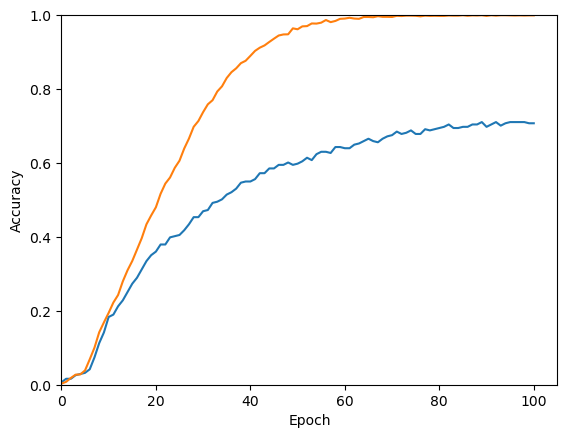

In [26]:
plt.plot(val_acc, label='Validation')
plt.plot(train_acc, label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, None);